# Overview

### Data handling

Original data is stored in the `raw/` directory. Formatted data from the Ndung'u and Ueno labs is stored in the `input/` directory, and in the tables `NEF_MUTANTS` and `NEF_STATS` below. We process this data using the scripts in the [dataset preparation](#dataset-preparation) section. 

Separately, we infer maximum entropy models to fit Nef sequence data downloaded from LANL, which is in the `couplings/` directory.

After inference and initial preparation of the dataset, we then [load the information](#dataset-load). If information on the phylogenetic distance between sequences and the Nef reference or information about sequence energies is missing, it is computed and loaded at this stage. Phylogenetic distances are computed externally using [FastME](http://www.atgc-montpellier.fr/fastme/). 

Note that both full energies (including both couplings and fields) and energies computed using fields only are recorded. Energies with fields only are computed directly from the logarithm of the correlations. Full energies are labeled by `Ex`, where `x` is the entropy threshold, and energies with fields only are labeled by `hx`.

### Analysis

All plots and analysis for the paper is contained in the [results](#results) section. Analysis makes extensive use of the Pandas dataframe `exp_df`, which contains all the experimental data, phylogenetic distances, and energy values. Figures are plotted using `mplot.py`, which interfaces with `matplotlib`. 

# Import packages

In [1]:
# Full library list and version numbers

print('This notebook was prepared using:')

import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
import scipy.stats as st
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import sklearn as sk
print('scikit-learn version %s' % sk.__version__)

import matplotlib
print('matplotlib version %s' % matplotlib.__version__)
%matplotlib inline

import os
import csv
import pickle
import shutil
import operator as op
import matplotlib.pyplot as plot

from imp import reload
from copy import deepcopy
from sklearn.linear_model import LinearRegression

This notebook was prepared using:
python version 3.7.3 (default, Mar 27 2019, 09:23:15) 
[Clang 10.0.1 (clang-1001.0.46.3)]
numpy version 1.16.4
scipy version 1.3.0
pandas version 0.24.2
scikit-learn version 0.21.2
matplotlib version 3.1.0


# Global variables

In [2]:
REPLACE = True  # replace existing variables with newly computed ones

NEF_CONSENSUS = ''.join("""
                  MGGKWSKRSVVGWPTVRERMRRAEPAADGVGAVSRDLEKHGAITSSNTAANNADCAWLEAQEEEEVGFP
                  VRPQVPLRPMTYKGALDLSHFLKEKGGLEGLIYSQKRQDILDLWVYHTQGYFPDWQNYTPGPGIRYPLT
                  FGWCFKLVPVEPEKVEEANEGENNSLLHPMSLHGMDDPEREVLVWKFDSRLAFHHMARELHPEYYKDC
                  """.split())

CONSENSUS_ENERGY = {
        'E0':  -648.956120,
        'E50': -657.798172,
        'E55': -665.057475,
        'E60': -670.995755,
        'E65': -676.613173,
        'E70': -666.563367,
        'E75': -696.173385,
        'E80': -718.148330,
        'E85': -755.631842,
        'E90': -812.451719,
        'h0':    32.084359,
        'h50':   32.675975,
        'h55':   32.961128,
        'h60':   32.961128,
        'h65':   32.961128,
        'h70':   33.317083,
        'h75':   33.317083,
        'h80':   33.413665,
        'h85':   33.413665,
        'h90':   33.447732
    }

NEF_MUTANTS = [                    # note: start from 1 convention
        [[17,'K']],
        [[19,'K']],
        [[17,'K'],[19,'K']],
        [[57,'R']],
        [[58,'P']],
        [[57,'R'],[58,'P']],
        [[57,'G']],
        [[72,'L']],
        [[75,'L']],
        [[72,'L'],[75,'L']],
        [[123,'G']],
        [[28,'E']],
        [[102,'H']],
        [[28,'E'],[102,'H']],
        [[102,'W']],
        [[28,'E'],[102,'W']],
        [[133,'T']],
        [[135,'F']],
        [[133,'T'],[135,'F']],
        [[188,'H']],
        [[192,'R']],
        [[188,'H'],[192,'R']],
        [[33,'A']],
        [[43,'L']],
        [[33,'A'],[43,'L']],
        [[43,'V']],
        [[143,'Y']],
        [[135,'F'],[143,'Y']],
        [[71,'K']],
        [[76,'V']],
        [[71,'K'],[76,'V']],
        [[71,'T']],
        [[71,'T'],[76,'V']],
        [[80,'D']],
        [[80,'N']],
        [[76,'V'],[80,'N']],
        [[88,'G']],
        [[43,'L'],[88,'G']],
        [[21,'K']],
        [[21,'E']]
    ]

NEF_STATS = [ 
           #RC,   CD4,   HLA
        [   -1,    -1,    -1],  #  17K
        [   -1,    -1,    -1],  #  19K
        [0.261, 1.013, 0.944],  #  17K  19K
        [0.008, 0.511, 1.017],  #  57R
        [   -1,    -1,    -1],  #  58P
        [0.001, 0.220, 1.026],  #  57R  58P
        [0.009, 0.138, 1.003],  #  57G
        [   -1,    -1,    -1],  #  72L
        [   -1,    -1,    -1],  #  75L
        [0.075, 0.653, 0.540],  #  72L  75L
        [0.064, 0.287, 0.320],  # 123G
        [0.851, 0.991, 0.977],  #  28E
        [0.466, 0.970, 0.887],  # 102H
        [1.394,    -1,    -1],  #  28E 102H
        [0.754, 1.008, 0.804],  # 102W
        [0.829, 1.002, 0.986],  #  28E 102W
        [0.599, 0.994, 0.907],  # 133T
        [1.143, 1.003, 0.974],  # 135F
        [1.463, 1.003, 0.967],  # 133T 135F
        [0.689, 0.989, 0.970],  # 188H
        [   -1, 1.008, 0.985],  # 192R
        [0.560, 0.995, 0.968],  # 188H 192R
        [1.293, 1.002, 1.005],  #  33A
        [0.694, 0.972, 1.038],  #  43L
        [0.881, 0.980, 0.982],  #  33A  43L
        [   -1,    -1,    -1],  #  43V
        [0.941, 0.978, 0.990],  # 143Y
        [1.034, 0.973, 0.961],  # 135F 143Y
        [0.854, 1.002, 0.972],  #  71K
        [0.843, 1.006, 0.931],  #  76V
        [1.065, 1.026, 0.937],  #  71K  76V
        [   -1,    -1,    -1],  #  71T
        [   -1,    -1,    -1],  #  71T  76V
        [0.186, 0.900, 0.966],  #  80D
        [0.832, 0.965, 1.006],  #  80N
        [0.531, 0.966, 0.868],  #  76V  80N
        [0.870, 0.997, 0.941],  #  88G
        [0.916, 0.947, 0.964],  #  43L  88G
        [0.515, 1.014, 0.961],  #  21K
        [1.464, 1.017, 0.977]   #  21E
        ]

# Define auxiliary functions

In [3]:
def read_CSV(ref):
    """ Returns a readable list from a CSV file. """
    
    f = open(ref, newline=None)
    r = csv.reader(f, delimiter=',')
    f.seek(0)
    
    csvfile = []
    tags    = []
    count   = 0
    
    for row in r:
        if count==0:
            tags   = row
            count += 1
        else:
            temp={}
            for i in range(len(tags)): temp[tags[i]] = row[i]
            csvfile.append(temp)
    
    return csvfile

def get_MSA(ref, HXB2seq=0, noHXB2=False, clip=False, noArrow=True):
    """ Take an input FASTA file and return the multiple sequence alignment, along with corresponding tags. """

    msatemp = [i.split() for i in open(ref).readlines()]
    msatemp = [i for i in msatemp if len(i)>0]
    msa = []
    tag = []
    
    for i in msatemp:
        if i[0][0]=='>':
            msa.append('')
            if noArrow: tag.append(i[0][1:])
            else:       tag.append(i[0])
        else: msa[-1]+=i[0]

    msa = np.array([list(i) for i in msa])

    if clip:
        msa = msa[:,msa[HXB2seq]!='-']
        msa = [list(i) for i in msa]
        if noHXB2:
            del msa[HXB2seq]
            del tag[HXB2seq]
        msa = np.array([list(i) for i in msa])
    
    return msa, tag

def save_MSA(msa, tag, fastawidth=80, out='alignment'):
    """ Write a multiple sequence alignment with corresponding tags as a FASTA file. """

    f=open(out+'.fasta','w')
    
    for i in range(len(msa)):
        f.write('>'+tag[i]+'\n')
        count=0
        while count<len(msa[i]):
            for j in range(fastawidth):
                f.write(msa[i][count])
                count+=1
                if count==len(msa[i]): break
            f.write('\n')


# Auxiliary functions: read in couplings and sequence map

def fopen(ref):
    """ Open a file and return a list of lines. """
    return [i.split() for i in open(ref).readlines()]

def s2l(x):
    """ Return the size (N) of a N*(N+1)/2 element vector, given its length. """
    return ((np.sqrt(1 + 8 * len(x)) - 1) / 2)

def pairs(N):
    """ Returns the ordered set of pairs of elements in {0, ..., N-1} for iterating. """
    pind=[]
    for i in range(N):
        for j in range(i+1,N): pind.append((i,j))
    return pind

def index(i,j,N):
    """ Returns the location of {i,j} in the set {{0,1},...,{N-2,N-1}}. """
    x = [i,j,N]
    x.sort()
    i, j, N = x[0], x[1], x[2]
    return int(i * (N - 2) - (i * (i - 1)) / 2 - 1 + j)

def sindex(i,j,qi,qj):
    """ Returns the location of {i,j} in the set {{0,0},{0,1},...,{0,qj-1},...{qi-1,qj-1}}. """
    return int((i * qj) + j)

def get_deleted(ref):
    """ Return the deleted positions (p=0 or p=1) from a report file. """
    return [int(i) for i in fopen(ref+'.rep')[7]]

def get_smap(ref):
    """ Return a map from AA sequence to Potts configuration from a .paa file. """
    with open(ref+'.paa','rb') as faa: smap=pickle.loads(faa.read())#, fix_imports=True, encoding='latin1')
    return smap

def get_J(ref, seqref='', **kwargs):
    """ Get couplings and fields from .j files. """
    return get_vec(ref, seqref, ext='.j', **kwargs)

def get_p(ref, seqref='', **kwargs):
    """ Get one- and two-point correlations from .p files. """
    return get_vec(ref, seqref, ext='.p', **kwargs)

def get_vec(ref, seqref='', ext='', **kwargs):
    """ Get couplings/correlations from files. """
    
    # Extract one- and two-point variables
    dat = fopen(ref+ext)
    N   = int(s2l(dat))
    v1  = np.array([np.array(i,float) for i in dat[:N]])
    v2  = np.array([np.array(i,float) for i in dat[N:]])
    
    # If there is a sequence reference, use this to determine deleted and vmin
    
    if seqref:
    
        # Get deleted sites and map from full index (including deleted sites) to reduced index
    
        deleted = get_deleted(seqref)
        newN    = N+len(deleted)
        idx     = []
        count   = 0
        
        for i in range(newN):
            if i in deleted: count+=1
            idx.append(i-count)
        
        # Fill in deleted entries
    
        vmin  = 0.0
        newv1 = []
        newv2 = []
        count = 0
        
        if ext=='.j': vmin = np.min([np.min(i) for i in v1])
        qstate = np.max([len(i) for i in v1])>1
        
        if qstate:
            vmin = np.array([vmin])
            for i in range(newN):
                if i in deleted: newv1.append(vmin)
                else:            newv1.append(v1[idx[i]])
            for i, j in pairs(newN):
                if i in deleted and j in deleted: newv2.append(np.zeros(1))
                elif i in deleted:                newv2.append(np.zeros(len(v1[idx[j]])))
                elif j in deleted:                newv2.append(np.zeros(len(v1[idx[i]])))
                else:                             newv2.append(v2[index(idx[i],idx[j],N)])
        
        else:
            vmin = np.array([vmin])
            for i in range(newN):
                if i in deleted: newv1.append(vmin)
                else:            newv1.append(v1[idx[i]])
            for i, j in pairs(newN):
                if i in deleted or j in deleted: newv2.append(np.zeros(1))
                else:                            newv2.append(v2[index(idx[i],idx[j],N)])
            
        v1=np.array(newv1)
        v2=np.array(newv2)

    return v1, v2


def get_E(h, J, smap, seq, passframeshift=False, passGaps=False, passX=True):
    """ Get the energy of an input amino acid sequence, using an input sequence map to convert 
        from sequence to Potts configuration. """
    
    # Sanity check
    
    assert len(h)==len(seq), 'Length mismatch! len(h) = %d, len(seq) = %d' % (len(h),len(seq))
    
    # Assign frameshift/gap/ambiguous codons to wild-type if specified
    
    if passframeshift:
        for i in range(len(smap)): smap[i]['#'] = 1
    
    if passGaps:
        for i in range(len(smap)): smap[i]['-'] = 1

    if passX:
        for i in range(len(smap)): smap[i]['X'] = 1
    
    # Get Potts configuration
    
    N       = len(seq)
    q       = [len(hh) for hh in h]
    pconfig = [smap[i][seq[i]] for i in range(N)]
    nz      = [i for i in range(N) if pconfig[i]!=0]

    # Compute energy

    E = 0.0

    for i in range(len(nz)):
        E -= h[nz[i]][pconfig[nz[i]]-1]
        for j in range(i+1,len(nz)):
            E -= J[index(nz[i],nz[j],N)][sindex(pconfig[nz[i]]-1,pconfig[nz[j]]-1,q[nz[i]],q[nz[j]])]

    return E


def get_E_fields(p1, smap, seq, passframeshift=False, passGaps=False, passX=True):
    """ Get the energy of an input amino acid sequence (fields only), using an input sequence map to convert 
        from sequence to Potts configuration. """
    
    # Sanity check
    
    assert len(p1)==len(seq), 'Length mismatch! len(h) = %d, len(seq) = %d' % (len(h),len(seq))
    
    # Assign frameshift/gap/ambiguous codons to wild-type if specified
    
    if passframeshift:
        for i in range(len(smap)): smap[i]['#'] = 1
    
    if passGaps:
        for i in range(len(smap)): smap[i]['-'] = 1

    if passX:
        for i in range(len(smap)): smap[i]['X'] = 1
    
    # Get Potts configuration
    
    N       = len(seq)
    pconfig = [smap[i][seq[i]] for i in range(N)]
    nz      = [i for i in range(N) if pconfig[i]!=0]

    #print(pconfig)
    #print(nz)
    
    # Compute energy

    E = 0.0
    
    for i in range(len(nz)):
        E -= np.log(p1[nz[i]][pconfig[nz[i]]-1])
    for i in range(N):
        if i not in nz:
            E -= np.log(1.-np.sum(p1[i]))

    return E

### Make maximum entropy inference jobs for cluster

In [ ]:
# Standard jobs
    
runstr = '#!/bin/bash\n#PBS -m abe\n#PBS -M jpbarton\n#PBS -k oe\n#PBS -j oe\n#PBS -l nodes=1:ppn=1\n'
runstr = runstr+'echo Running on host `hostname`\necho Time is `date`\necho Directory is `pwd`\n'

svals = [0.00, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
tags  = ['S'+str(int(100*s)) for s in svals]
B     = {'B' : 3300., 'C' : 1656.}
gamma = {}
for c in ['B', 'C']:
    gamma[c] = (5. * 206) / B[c]

for c in ['B', 'C']:
    frun = open('jobs/run-nef-%s-qsce.sh' % (c), 'w')
    grun = open('jobs/run-nef-%s-qlearn.sh' % (c), 'w')
    for t in tags:
        nt = 'nef-%s-%s' % (c, t)
        f  = open('jobs/%s-qsce.pbs' % (nt), 'w')
        g  = open('jobs/%s-qlearn.pbs' % (nt), 'w')
        
        f.write('%s./qsce.out -d nef -i %s -o %s -gi -g2 %lf -b %d -mcb 80000 -kmin 4 > /dev/null\n' % 
                (runstr, nt, 'fit/'+nt, gamma[c], B[c]))
        f.close()
        frun.write('qsub -q verylong nef/jobs/%s-qsce.pbs > /dev/null\n' % (nt))
        
        g.write('%s./qlearnsparse.out -d nef -c %s -i %s -o %s -gi -g2 %lf -b %d -e 1.0 > /dev/null\n' % 
                (runstr, nt, 'fit/'+nt, 'fit/'+nt+'-learn', gamma[c], B[c]))
        g.close()
        grun.write('qsub -q verylong nef/jobs/%s-qlearn.pbs > /dev/null\n' % (nt))
    
    frun.close()
    grun.close()

<a id='dataset-preparation'></a>

# Dataset preparation: RUN ONCE

### Import data files from Thumbi Ndung'u (clade C) and Takamasa Ueno (clade B).

In [ ]:
# Convert and save previous synthetic Nef sequences and experimental measurements

f = open('input/Nef-Ndungu-synthetic.csv', 'w')
f.write('pid,status,clade,CD4,HLA,RC,sequence\n')

for i in range(len(NEF_MUTANTS)):
    name   = '_'.join([str(j[0])+j[1] for j in NEF_MUTANTS[i]]).lower()
    mutseq = [j for j in NEF_CONSENSUS]
    for mut in NEF_MUTANTS[i]: mutseq[mut[0]-1]=mut[1] # note shift from 1 --> 0 convention
    f.write(name+',synthetic,B,')
    
    CD4val = NEF_STATS[i][1]
    HLAval = NEF_STATS[i][2]
    RCval  = NEF_STATS[i][0]
    
    if CD4val!=-1: f.write('%lf,' % (CD4val * 100.))
    else:          f.write('NA,')
    if HLAval!=-1: f.write('%lf,' % (HLAval * 100.))
    else:          f.write('NA,')
    if RCval!=-1:  f.write('%lf,' % (RCval * 100.))
    else:          f.write('NA,')
        
    f.write('%s\n' % ''.join(mutseq))

f.close()

In [ ]:
# Data structure for future use

exp_table      = []
exp_table_vars = ['pid','status','clade','CD4 count','pVL',
                  'CD4','CXCR4','CCR5','HLA','CD74','infectivity','RC','sequence']

# Data from Ndung'u

d = read_CSV('input/Nef-Ndungu.csv')

for obs in d:
    exp_table.append({})
    exp_table[-1]['pid']         = '_'.join(obs['pid'].lower().split())
    exp_table[-1]['status']      = obs['status'].lower()
    exp_table[-1]['clade']       = 'C'
    exp_table[-1]['CD4 count']   = 'NA'
    exp_table[-1]['pVL']         = 'NA'
    exp_table[-1]['CD4']         = float(obs['CD4']) * 100.  # Convert to %
    exp_table[-1]['CXCR4']       = 'NA'
    exp_table[-1]['CCR5']        = 'NA'
    exp_table[-1]['HLA']         = float(obs['HLA']) * 100.  # Convert to %
    exp_table[-1]['CD74']        = 'NA'
    exp_table[-1]['infectivity'] = 'NA'
    exp_table[-1]['RC']          = 'NA'
    exp_table[-1]['sequence']    = obs['sequence']
    
# Data from Ndung'u (synthetic)

d = read_CSV('input/Nef-Ndungu-synthetic.csv')

for obs in d:
    exp_table.append({})
    exp_table[-1]['pid']         = '_'.join(obs['pid'].lower().split())
    exp_table[-1]['status']      = obs['status'].lower()
    exp_table[-1]['clade']       = obs['clade']
    exp_table[-1]['CD4 count']   = 'NA'
    exp_table[-1]['pVL']         = 'NA'
    exp_table[-1]['CD4']         = float(obs['CD4']) if obs['CD4']!='NA' else 'NA'
    exp_table[-1]['CXCR4']       = 'NA'
    exp_table[-1]['CCR5']        = 'NA'
    exp_table[-1]['HLA']         = float(obs['HLA']) if obs['HLA']!='NA' else 'NA'
    exp_table[-1]['CD74']        = 'NA'
    exp_table[-1]['infectivity'] = 'NA'
    exp_table[-1]['RC']          = float(obs['RC'])  if obs['RC']!='NA'  else 'NA'
    exp_table[-1]['sequence']    = obs['sequence']
    
# Data from Ueno

uStart = len(exp_table)
d      = read_CSV('input/Nef-Ueno.csv')

for obs in d:
    exp_table.append({})
    exp_table[-1]['pid']         = '_'.join(obs['Patient ID'].lower().split())
    exp_table[-1]['status']      = obs['cohort'].lower()
    exp_table[-1]['clade']       = 'B'
    exp_table[-1]['CD4 count']   = float(obs['CD4 count'])   if obs['CD4 count']  !='NA' else 'NA'
    exp_table[-1]['CD4']         = float(obs['CD4'])         if obs['CD4']        !='NA' else 'NA'
    exp_table[-1]['CXCR4']       = float(obs['CXCR4'])       if obs['CXCR4']      !='NA' else 'NA'
    exp_table[-1]['CCR5']        = float(obs['CCR5'])        if obs['CCR5']       !='NA' else 'NA'
    exp_table[-1]['HLA']         = float(obs['HLA'])         if obs['HLA']        !='NA' else 'NA'
    exp_table[-1]['CD74']        = float(obs['CD74'])        if obs['CD74']       !='NA' else 'NA'
    exp_table[-1]['infectivity'] = float(obs['infectivity']) if obs['infectivity']!='NA' else 'NA'
    exp_table[-1]['RC']          = float(obs['RC'])          if obs['RC']         !='NA' else 'NA'
    exp_table[-1]['sequence']    = obs['translatedMix']
    
    if obs['pVL'][0]=='<': exp_table[-1]['pVL'] = float(obs['pVL'][1:])  # pin viral load to lower bound
    elif obs['pVL']=='NA': exp_table[-1]['pVL'] = 'NA'
    else:                  exp_table[-1]['pVL'] = float(obs['pVL'])

# Ueno sequences are not aligned to HXB2 -- to fix this, export a fasta file of sequences that we will align

f = open('input/Nef-Ueno-nuc.fasta', 'w')

for obs in d:
    if obs['Patient ID']=='AC184-E00150A':   # No DNA for AC184-E00150A, this sequence has been HAND ALIGNED to HXB2
        continue
    else:
        f.write('>'+('_'.join(obs['Patient ID'].lower().split()))+'\n')
        f.write(obs['sequence']+'\n')        # NUCLEOTIDE sequences that we will let LANL translate and align
    
f.close()

# Align the sequences, save as input/Nef-Ueno-aligned.fasta, then run below

In [ ]:
# Replace stored sequences with clipped, aligned sequences (drop final stop codon)

msa, tag = get_MSA('input/Nef-Ueno-aligned.fasta', clip=True)

for i in range(uStart,len(exp_table)):
    label = '_'.join(d[i-uStart]['Patient ID'].lower().split())
    idx   = tag.index(label)
    exp_table[i]['sequence'] = ''.join(msa[idx][:-1])

# Save merged table to file

f = open('input/Nef-merged.csv', 'w')
f.write('%s\n' % ','.join(exp_table_vars))

for obs in exp_table:
    for var in exp_table_vars[:-1]: f.write(str(obs[var])+',')
    f.write(obs[exp_table_vars[-1]]+'\n')

f.close()

if not os.path.isfile('output/Nef-merged-all.csv'):
    shutil.copyfile('input/Nef-merged.csv', 'output/Nef-merged-all.csv')

# Save an alignment of all sequences

Bcons = ''.join(fopen('couplings/nef-B-S80.rep')[3])
Ccons = ''.join(fopen('couplings/nef-C-S80.rep')[3])

msa, tag = [Bcons, Ccons], ['Bcons', 'Ccons']

for obs in exp_table:
    tag.append(obs['pid'])
    msa.append(obs['sequence'])
    
save_MSA(msa, tag, out='output/Nef-aligned')  # Manually add HXB2 (output/HXB2-aligned.fasta)

<a id='dataset-load'></a>

# Load dataset: ALWAYS RUN

In [4]:
# Read in data and add clade-specific distance measure

exp_df = pd.read_csv('output/Nef-merged-all.csv', memory_map=True)

### If not loaded, compute HIVb sequence distance matrix using FastME

Source: http://www.atgc-montpellier.fr/fastme/usersguide.php

Using FastME 2.1.5, distance matrices computed with commands:

```
cd output
perl Fasta2Phylip.pl Nef-aligned.fasta Nef-aligned.phylip
cd ..
./fastme-2.1.5/src/fastme -i output/Nef-aligned.phylip -O output/Nef-aligned-distance-matrix.dat --protein=HIVb -c
```

In [ ]:
# Get HIVb distances between sequences using FastME 
# ./fastme-2.1.5/src/fastme -i output/Nef-aligned.phylip -O output/Nef-aligned-distance-matrix.dat --protein=HIVb -c

if 'd' not in exp_df.columns or REPLACE:

    d            = fopen('output/Nef-aligned-distance-matrix.dat')[1:-1]
    tag          = [i[0]                  for i in d]
    distMatrix   = [np.array(i[1:],float) for i in d]
    
    # Save distances to file
    
    dB     = []
    dC     = []
    dclade = []

    for i in range(len(exp_df)):
        dB.append(distMatrix[tag.index('Bcons')][tag.index(exp_df.iloc[i].pid)])
        dC.append(distMatrix[tag.index('Ccons')][tag.index(exp_df.iloc[i].pid)])
        if exp_df.iloc[i].clade=='B': dclade.append(dB[-1])
        else:                         dclade.append(dC[-1])

    exp_df['d']  = pd.Series(dclade, index=exp_df.index)
    exp_df['dB'] = pd.Series(dB, index=exp_df.index)
    exp_df['dC'] = pd.Series(dC, index=exp_df.index)
    
    exp_df.to_csv('output/Nef-merged-all.csv', na_rep='NA')

### If not loaded, compute energy for each sequence and record

In [ ]:
if 'E0' not in exp_df.columns or REPLACE:
    
    # Point to coupling values for computing energies
    
    bestjs   = {'B' : {}, 'C' : {}}
    bestseqs = {'B' : {}, 'C' : {}}
    svals    = [0.00, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

    for s in svals:
        for c in ['B', 'C']:
            bestjs[c][s]   = 'couplings/nef-'+c+'-S'+str(int(100*s))
            bestseqs[c][s] = 'couplings/nef-'+c+'-S'+str(int(100*s))

    # Iterate through all sequences and compute energies

    Evals  = {}
    Ehvals = {}
    stags  = ['E'+str(int(100*s)) for s in svals]+['h'+str(int(100*s)) for s in svals]
    smap   = {}
    h      = {}
    J      = {}
    p1     = {}
    p2     = {}

    for clade in ['B','C']:
        smap[clade] = {}
        h[clade]    = {}
        J[clade]    = {}
        p1[clade]   = {}
        p2[clade]   = {}

    for s in svals:
        Evals[s]  = []
        Ehvals[s] = []
        for clade in ['B','C']:
            jref   = bestjs[clade][s]
            seqref = bestseqs[clade][s]
            smap[clade][s]             = get_smap(seqref)
            h[clade][s], J[clade][s]   = get_J(jref, seqref)
            p1[clade][s], p2[clade][s] = get_p(seqref, seqref)

    for i in range(len(exp_df)):
        clade = exp_df.iloc[i].clade

        for s in svals:
            Evals[s].append(get_E(h[clade][s], J[clade][s], smap[clade][s], exp_df.iloc[i].sequence))
            Ehvals[s].append(get_E_fields(p1[clade][s], smap[clade][s], exp_df.iloc[i].sequence))
    
    for s in svals:
        exp_df['E'+str(int(100*s))] = pd.Series(Evals[s], index=exp_df.index)
        exp_df['h'+str(int(100*s))] = pd.Series(Ehvals[s], index=exp_df.index)
    
    for s in stags:
        key = float(s[1:])/100
        if 'E' in s:
            CONSENSUS_ENERGY[s] = get_E(h['B'][key], J['B'][key], smap['B'][key], [i for i in NEF_CONSENSUS])
        else:
            CONSENSUS_ENERGY[s] = get_E_fields(p1['B'][key], smap['B'][key], [i for i in NEF_CONSENSUS])
        
    exp_df.to_csv('output/Nef-merged-all.csv', na_rep='NA')

<a id='results'></a>

# Results

### Figure conventions

In [5]:
# Plotting conventions

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec

import mplot as mp

# Plot conventions

def cm2inch(x): return float(x)/2.54
single_column   = cm2inch(8.9)  
one_five_column = cm2inch(11.4) 
double_column   = cm2inch(18.3) 

goldr        = (1.0 + np.sqrt(5)) / 2.0
bkcolor      = '#252525'
altcolor     = '#3182bd'
fontfamily   = 'Arial'
sizeline     = 0.6
sizesublabel = 8
sizelabel    = 7#6
sizetick     = 6#5
ticklength   = 3
tickpad      = 3
axwidth      = 0.4

figprops = {
    'transparent' : True,
    #'bbox_inches' : 'tight'
    }

def_barprops = {
    'lw'          : sizeline/2,
    'width'       : 0.25,
    'edgecolor'   : bkcolor,
    'align'       : 'center', #other option: edge
    'orientation' : 'vertical'
    }

def_histprops = {
    'histtype'    : 'bar',
    'lw'          : sizeline/2,
    'rwidth'      : 0.8,
    'ls'          : 'solid',
    'edgecolor'   : bkcolor,
    'alpha'       : 0.5
    }

def_lineprops = {
    'lw' : sizeline, 
    'ls' : '-'
    }

def_labelprops = {
    'family' : fontfamily,
    'size'   : sizelabel,
    'color'  : bkcolor
    }

def_sublabelprops = {
    'family' : fontfamily,
    'size'   : sizesublabel,
    'weight' : 'bold',
    'ha'     : 'center',
    'va'     : 'center',
    'color'  : 'k'
    }

def_ticklabelprops = {
    'family' : fontfamily,
    'size'   : sizetick,
    'color'  : bkcolor
    }

def_tickprops = {
    'length'    : ticklength,
    'width'     : axwidth/2,
    'pad'       : tickpad,
    'axis'      : 'both',
    'direction' : 'out',
    'colors'    : bkcolor,
    'bottom'    : True,
    'left'      : True,
    'top'       : False,
    'right'     : False
    }

def_minortickprops = {
    'length'    : ticklength-1.25,
    'width'     : axwidth/2,
    'axis'      : 'both',
    'direction' : 'out',
    'which'     : 'minor',
    'color'     : bkcolor
    }

def_axprops = {
    'linewidth' : axwidth,
    'linestyle' : '-',
    'color'     : bkcolor
    }

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'mathtext.default' : 'regular'}
plot.rcParams.update(params)

### Comparison of E values for mutants at the same site

In [6]:
EVars = ['E0', 'E90']
noNA  = [exp_df[[tag, 'clade', 'status', 'pid']+EVars].dropna() for tag in ['RC','CD4','HLA']]
noNA  = [n[(n.clade=='B') & (n.status=='synthetic')] for n in noNA]

a0  = CONSENSUS_ENERGY['E0']
a90 = CONSENSUS_ENERGY['E90']

# Compare energies for variants at the same site

#COMPARE TO ENERGY OF NL4-3
print('\tIsing\tPotts\n')
for id_f, id_u in [['57r', '57g'], ['80n', '80d'], ['102w', '102h'], ['28e_102h', '28e_102w'], ['21e', '21k']]:
    spc = '\t'
    if len(id_f)<8:
        spc = '\t\t'
    print('  fit (%s)%s%.2f\t%.2f' % 
          (id_f, spc, noNA[0][noNA[0].pid==id_f].E0-a0, noNA[0][noNA[0].pid==id_f].E90-a90))
    print('unfit (%s)%s%.2f\t%.2f' % 
          (id_u, spc, noNA[0][noNA[0].pid==id_u].E0-a0, noNA[0][noNA[0].pid==id_u].E90-a90))
    print('')


for i in range(len(noNA[0])):
    name   = noNA[0].iloc[i].pid
    spacer = '\t'
    if len(name)<8:
        spacer = '\t\t'
    print('%s%s%.2f\t\t%.2f' % (name, spacer, noNA[0].iloc[i].E0-a0, noNA[0].iloc[i].E90-a90))

	Ising	Potts

  fit (57r)		4.63	5.53
unfit (57g)		4.63	6.25

  fit (80n)		3.58	4.30
unfit (80d)		3.58	4.37

  fit (102w)		0.31	1.85
unfit (102h)		0.31	0.60

  fit (28e_102h)	0.61	1.17
unfit (28e_102w)	0.61	2.41

  fit (21e)		0.89	2.57
unfit (21k)		0.89	1.55

17k_19k		6.45		7.54
57r		4.63		5.53
57r_58p		7.44		8.32
57g		4.63		6.25
72l_75l		11.75		12.77
123g		6.05		6.84
28e		0.22		0.51
102h		0.31		0.60
28e_102h	0.61		1.17
102w		0.31		1.85
28e_102w	0.61		2.41
133t		-0.11		0.47
135f		1.15		1.20
133t_135f	0.64		1.20
188h		1.34		2.40
188h_192r	2.40		3.82
33a		0.72		0.65
43l		1.67		1.89
33a_43l		2.02		2.11
143y		2.93		2.90
135f_143y	4.16		4.18
71k		1.63		1.81
76v		3.51		3.65
71k_76v		5.14		5.47
80d		3.58		4.37
80n		3.58		4.30
76v_80n		7.10		7.95
88g		3.99		4.32
43l_88g		5.63		6.17
21k		0.89		1.55
21e		0.89		2.57


### Figure 1. Energy vs. Nef function for synthetic sequences.

In [7]:
EVars = ['E'+str(int(100*s)) for s in [0.90]]

RCpvec, CD4pvec, HLApvec = [], [], []
RCsvec, CD4svec, HLAsvec = [], [], []
RCppvec                  = []
labels = ['0.9']

synth = exp_df[['pid','RC','CD4','HLA','clade','status']+EVars]
synth = synth[(synth.clade=='B') & (synth.status=='synthetic')]

noNA = [exp_df[[tag, 'clade', 'status']+EVars].dropna() for tag in ['RC','CD4','HLA']]
noNA = [n[(n.clade=='B') & (n.status=='synthetic')] for n in noNA]

corrvec = []

for tag in EVars:

    corrvec.append(st.spearmanr(noNA[0][tag],noNA[0]['RC']))
    corrvec.append(st.spearmanr(noNA[0][tag],noNA[1]['CD4']))
    corrvec.append(st.spearmanr(noNA[0][tag],noNA[2]['HLA']))

    E_good = np.array(noNA[1][noNA[1].CD4 >80.][tag])
    E_bad  = np.array(noNA[1][noNA[1].CD4<=80.][tag])
    all_same = True
    for eg in E_good:
        for eb in E_bad:
            if eg!=eb:
                all_same = False
                break
    if all_same:
        u, p = 0, 0
    else:
        u, p = st.mannwhitneyu(E_good, E_bad)
    print('%s\tMann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=%d, p=%lf' % (tag,u,2*p))

    E_good = np.array(noNA[2][noNA[2].HLA >80.][tag])
    E_bad  = np.array(noNA[2][noNA[2].HLA<=80.][tag])
    all_same = True
    for eg in E_good:
        for eb in E_bad:
            if eg!=eb:
                all_same = False
                break
    if all_same:
        u, p = 0, 0
    else:
        u, p = st.mannwhitneyu(E_good, E_bad)
    print('%s\tMann Whitney U test (difference in energy w/ and w/out HLA impairment): U=%d, p=%lf' % (tag,u,2*p))

    # Choose how to categorize each mutant as functional or impaired for CD4/HLA down-modulation, 
    # use this to set point size

CD4thresh = 0.8
HLAthresh = 0.8

x    = [[] for k in range(3)]
y    = [[] for k in range(3)]
yerr = [[] for k in range(3)]

RC_rep  = pd.read_csv('input/RC-replicates.csv',  memory_map=True)
CD4_rep = pd.read_csv('input/CD4-replicates.csv', memory_map=True)
HLA_rep = pd.read_csv('input/HLA-replicates.csv', memory_map=True)

for i in range(len(EVars)):
    dfE = np.array(synth[EVars[i]]-CONSENSUS_ENERGY[EVars[i]])
    
    for k in range(len(synth)):
        tag = (''.join(synth.iloc[k]['pid'].split('_'))).upper()
        E   = synth.iloc[k][EVars[i]] - CONSENSUS_ENERGY[EVars[i]]

        if tag in list(RC_rep.pid):
            mean = (RC_rep[RC_rep.pid==tag].iloc[0].r1 + RC_rep[RC_rep.pid==tag].iloc[0].r2)/(2 * 100)
            dRC  = np.fabs(mean - RC_rep[RC_rep.pid==tag].iloc[0].r1/100)
            x[0].append(E)
            y[0].append(mean)
            yerr[0].append(dRC)
            
        if tag in list(CD4_rep.pid):
            mean = (CD4_rep[CD4_rep.pid==tag].iloc[0].r1 + CD4_rep[CD4_rep.pid==tag].iloc[0].r2)/2
            dCD4 = np.fabs(mean - CD4_rep[CD4_rep.pid==tag].iloc[0].r1)
            x[1].append(E)
            y[1].append(mean)
            yerr[1].append(dCD4)
            
        if tag in list(HLA_rep.pid):
            mean = (HLA_rep[HLA_rep.pid==tag].iloc[0].r1 + HLA_rep[HLA_rep.pid==tag].iloc[0].r2)/2
            dHLA = np.fabs(mean - HLA_rep[HLA_rep.pid==tag].iloc[0].r1)
            x[2].append(E)
            y[2].append(mean)
            yerr[2].append(dHLA)
        
#     dfRC  = np.array(synth['RC'])/100.
#     dfCD4 = np.array(synth['CD4'])/100.
#     dfHLA = np.array(synth['HLA'])/100.
    
#     for k in range(len(dfE)):
#         x[0].append(dfE[k])
#         x[1].append(dfE[k])
#         x[2].append(dfE[k])
#         y[0].append(dfRC[k])
#         y[1].append(dfCD4[k])
#         y[2].append(dfHLA[k])

# Define plot

w     = single_column
goldh = 3 * single_column / goldr

fig = plot.figure(figsize=(w, goldh))
gs  = gridspec.GridSpec(3, 1, height_ratios=[1.0, 1.0, 1.0], width_ratios=[1])
ax    = [0 for i in range(3)]
ax[0] = plot.subplot(gs[  0, 0])  # Overall correlation w/RC,  S_T=0.9
ax[1] = plot.subplot(gs[  1, 0])  # Overall correlation w/CD4, S_T=0.9
ax[2] = plot.subplot(gs[  2, 0])  # Overall correlation w/HLA, S_T=0.9

# MAKE SUBPLOTS - RC vs E

legendprops  = { 'loc' : 2, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : -0.25, 
                    'prop' : {'size' : sizelabel-1}, 'bbox_to_anchor' : (0.45, 1.24), 'ncol' : 1 }

scatterprops = [{ 'lw' : 0.5, 's' :  4, 'marker' : 'o'},#, 'label' : 'both impaired'    },
                { 'lw' : 0.5, 's' :  8, 'marker' : 'o', 'label' : 'CD4/HLA impaired' },
                { 'lw' : 0.5, 's' : 16, 'marker' : 'o', 'label' : 'both functional'  }]
errorprops = {'mew': sizeline, 'markersize': 3, 'fmt': 'o', 
              'elinewidth': sizeline, 'capthick': 0, 'capsize': 0}

colorlist = ['#e31a1c', '#fd8d3c', '#fecc5c']

idxlist      = [0, 5, -1]
sublabellist = ['A', 'B', 'C']
ylabellist   = ['Replication capacity', 'CD4 down-modulation', 'HLA down-modulation']
stlist       = ['Potts,\,S_T=0.9', 'Potts,\,S_T=0.9', 'Potts,\,S_T=0.9']
slc          = [-0.15, 0.9]
corry        = [1.2, 0.8, 0.8]
cVec         = ['#feb24c', '#88419d', '#9ebcda','#bfd3e6','#f03b20', ]

for i in range(len(y)):

    pprops = { 'edgecolor'      : [cVec[i]],
               'xlim'           : [-0.5, 20],
               'ylim'           : [0, 1.6],
               'xticks'         : [0, 3, 6, 9, 12, 15],
               'yticks'         : [0, 0.5, 1.0, 1.5],
               'xlabel'         : r'$\Delta$' +'Energy '+(r'$(%s)$' % stlist[i]),
               'ylabel'         : ylabellist[i],
               'sublabel'       : sublabellist[i],
               'sublabelcoords' : slc }

    if i>0:
        pprops['ylim'] = [0, 1.1]
        pprops['yticks'] = [0, 0.5, 1.0]
    mp.plot(type='error', ax=ax[i], x=[x[i]], y=[y[i]], yerr=[yerr[i]], 
                facecolor=[cVec[i]], plotprops=errorprops, **pprops)

    r_value, p_value = corrvec[i]
    pexp             = np.floor(np.log10(p_value))
    pcoeff           = np.round(p_value * (10. ** (-pexp)))
    ax[i].text(12.5, corry[i], (r'$\rho=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
               ha='left', va='bottom', **def_labelprops)

# Save data

plot.tight_layout()
plot.savefig('figures/fig1-correlation.pdf', **figprops)
plot.close(fig)


E90	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=7, p=0.002013
E90	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040324


### Figure 3. Comparison between CD4/HLA down-modulation and replication.

In [8]:
EVars = 'E90'
synth = exp_df[['RC','CD4','HLA','clade','status']+[EVars]]
synth = synth[(synth.clade=='B') & (synth.status=='synthetic')]

noNA = [exp_df[[tag, 'clade', 'status']+[EVars]].dropna() for tag in ['RC','CD4','HLA']]
noNA = [n[(n.clade=='B') & (n.status=='synthetic')] for n in noNA]

CD4vec = np.array(noNA[1].CD4)/100.
ECD4   = np.array(noNA[1][EVars])-CONSENSUS_ENERGY[EVars]
HLAvec = np.array(noNA[2].HLA)/100.
EHLA   = np.array(noNA[2][EVars])-CONSENSUS_ENERGY[EVars]

# Define plot

w2    = 0.8
w     = double_column
goldh = 1.31 * one_five_column / (1.0 + w2)

fig = plot.figure(figsize=(w, goldh))
gs  = gridspec.GridSpec(2, 5, height_ratios=[1.0, 1.0], width_ratios=[0.2, w2, 0.5, 0.5, 0.2])
ax1 = plot.subplot(gs[ 0,  1])  # CD4 vs E
ax2 = plot.subplot(gs[ 1,  1])  # HLA vs E
axl = plot.subplot(gs[ 0:, 0])  # left buffer
axr = plot.subplot(gs[ 0:, 4])  # right buffer
    
for axis in ['left', 'right', 'bottom', 'top']:
    axl.spines[axis].set_visible(False)
    axr.spines[axis].set_visible(False)
    
axl.set_xticks([])
axl.set_yticks([])
axr.set_xticks([])
axr.set_yticks([])

# MAKE SUBPLOTS - CD4/HLA vs E

scatterprops = { 'lw' : 0.5, 's' : 10, 'marker' : 'o'}
    
slc = [-0.23, 0.95]
    
xposL  = 0.30
xposR  = 0.67
cutoff = 0.8
ymod   = 1.1
tol    = np.fabs(np.max(ECD4)-np.min(ECD4))/25.0
    
classL = [i for i in range(len(CD4vec)) if CD4vec[i]<cutoff]
classR = [i for i in range(len(CD4vec)) if CD4vec[i]>=cutoff]

for c in classL, classR:
    for i in np.arange(np.min(ECD4),np.max(ECD4)+ymod*tol,ymod*tol):
        ygroup=[]
        for j in range(len(c)):
            if np.fabs(ECD4[c[j]]-i)<ymod*tol/2.0: ygroup.append(c[j])
        if len(ygroup)==1:
            if c==classL: CD4vec[ygroup[0]]=xposL
            if c==classR: CD4vec[ygroup[0]]=xposR
        elif len(ygroup)>1:
            dx    = 0.04
            width = np.min([dx * float(len(ygroup)), 0.2])
            ddx    = width/(float(len(ygroup))-1.0)
            space = []
            if c==classL: space=np.arange(xposL-width/2.0,xposL+width/2.0+ddx,ddx)
            if c==classR: space=np.arange(xposR-width/2.0,xposR+width/2.0+ddx,ddx)
            for j in range(len(ygroup)): CD4vec[ygroup[j]]=space[j]
    
pprops = {  'colors'         : ['#E48B8B'], #'#D2292D'],
            'edgecolor'      : [bkcolor],
            'xlim'           : [0, 1],
            'ylim'           : [-1.5, 20],
            'xticks'         : [xposL, xposR],
            'xticklabels'    : ['impaired', 'functional'],
            'yticks'         : [0, 5, 10, 15, 20],
            'ylabel'         : 'Energy '+r'$(S_T=0)$',
            'xlabel'         : 'CD4 down-modulation',
            'sublabel'       : 'A',
            'sublabelcoords' : slc }

mp.plot(type='scatter', ax=ax1, x=[CD4vec], y=[ECD4], facecolor=['#E48B8B'], plotprops=scatterprops, **pprops)

xposL  = 0.30
xposR  = 0.67
cutoff = 0.8
ymod   = 1.1
tol    = np.fabs(np.max(EHLA)-np.min(EHLA))/25.0
    
classL = [i for i in range(len(HLAvec)) if HLAvec[i]<cutoff]
classR = [i for i in range(len(HLAvec)) if HLAvec[i]>=cutoff]

for c in classL, classR:
    for i in np.arange(np.min(EHLA),np.max(EHLA)+ymod*tol,ymod*tol):
        ygroup=[]
        for j in range(len(c)):
            if np.fabs(EHLA[c[j]]-i)<ymod*tol/2.0: ygroup.append(c[j])
        if len(ygroup)==1:
            if c==classL: HLAvec[ygroup[0]]=xposL
            if c==classR: HLAvec[ygroup[0]]=xposR
        elif len(ygroup)>1:
            dx    = 0.04
            width = np.min([dx * float(len(ygroup)), 0.2])
            ddx    = width/(float(len(ygroup))-1.0)
            space = []
            if c==classL: space=np.arange(xposL-width/2.0,xposL+width/2.0+ddx,ddx)
            if c==classR: space=np.arange(xposR-width/2.0,xposR+width/2.0+ddx,ddx)
            for j in range(len(ygroup)): HLAvec[ygroup[j]]=space[j]

pprops = {  'colors'         : ['#a1d99b'], #'#31a354'],
            'edgecolor'      : [bkcolor],
            'xlim'           : [0, 1],
            'ylim'           : [-1.5, 20],
            'xticks'         : [xposL, xposR],
            'xticklabels'    : ['impaired', 'functional'],
            'yticks'         : [0, 5, 10, 15, 20],
            'ylabel'         : 'Energy '+r'$(S_T=0)$',
            'xlabel'         : 'HLA down-modulation',
            'sublabel'       : 'B',
            'sublabelcoords' : slc }

mp.plot(type='scatter', ax=ax2, x=[HLAvec], y=[EHLA], facecolor=['#a1d99b'], plotprops=scatterprops, **pprops)

            
# MAKE SUBPLOTS - CD4/HLA/RC matrix

RC     = np.array([i[0] for i in NEF_STATS])
CD4    = np.array([i[1] for i in NEF_STATS])
HLA    = np.array([i[2] for i in NEF_STATS])
x      = [CD4, HLA, RC]
xlim   = [[-0.08, 1.08], [-0.08, 1.08], [-0.1, 1.6]]

has2 = RC!=-1
has0 = CD4!=-1
has1 = HLA!=-1

ax00 = plot.subplot(gs[  0,  2])    # HLA vs CD4
ax01 = plot.subplot(gs[  0,  3])    # RC  vs CD4
ax11 = plot.subplot(gs[  1,  3])    # RC  vs HLA
#ax10 = plot.subplot(gs[  1,  2])    # blank

xlabelprops = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
ylabelprops = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }

pprops = {  'colors'    : [bkcolor],
            'edgecolor' : [bkcolor],
            'xlim'      : [k for k in xlim[1]],
            'ylim'      : [k for k in xlim[0]],
            'xticks'    : [0, 0.5, 1.0],
            'yticks'    : [0, 0.5, 1.0],
            'xlabel'    : 'HLA down-modulation',
            'ylabel'    : 'CD4 down-modulation',
            'theme'     : 'boxed',
            'sublabel'       : 'C',
            'sublabelcoords' : [-0.45, 0.9]  }

mp.plot(type='scatter', ax=ax00, x=[x[1]], y=[x[0]], facecolor=['#cccccc'], plotprops=scatterprops, **pprops)
hasBoth = has1 * has0
r_value, p_value = st.spearmanr(x[1][hasBoth],x[0][hasBoth])
pexp             = np.floor(np.log10(p_value))
pcoeff           = np.round(p_value * (10. ** (-pexp)))
ax00.text(0, 0.75, (r'$\rho=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
               ha='left', va='bottom', **def_labelprops)

pprops = {  'colors'    : [bkcolor],
            'edgecolor' : [bkcolor],
            'xlim'      : [k for k in xlim[2]],
            'ylim'      : [k for k in xlim[0]],
            'xticks'    : [0, 0.5, 1.0, 1.5],
            'yticks'    : [0, 0.5, 1.0],
            'xlabel'    : 'Replication capacity',
            'ylabel'    : 'CD4 down-modulation',
            'theme'     : 'boxed' }
    
mp.plot(type='scatter', ax=ax01, x=[x[2]], y=[x[0]], facecolor=['#cccccc'], plotprops=scatterprops, **pprops)
hasBoth = has2 * has0
r_value, p_value = st.spearmanr(x[2][hasBoth],x[0][hasBoth])
pexp             = np.floor(np.log10(p_value))
pcoeff           = np.round(p_value * (10. ** (-pexp)))
ax01.text(0.6, 0.05, (r'$\rho=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
               ha='left', va='bottom', **def_labelprops)

pprops = {  'colors'    : [bkcolor],
            'edgecolor' : [bkcolor],
            'xlim'      : [k for k in xlim[2]],
            'ylim'      : [k for k in xlim[1]],
            'xticks'    : [0, 0.5, 1.0, 1.5],
            'yticks'    : [0, 0.5, 1.0],
            'xlabel'    : 'Replication capacity',
            'ylabel'    : 'HLA down-modulation',
            'theme'     : 'boxed' }
    
mp.plot(type='scatter', ax=ax11, x=[x[2]], y=[x[1]], facecolor=['#cccccc'], plotprops=scatterprops, **pprops)
hasBoth = has2 * has1
r_value, p_value = st.spearmanr(x[2][hasBoth],x[1][hasBoth])
pexp             = np.floor(np.log10(p_value))
pcoeff           = np.round(p_value * (10. ** (-pexp)))
ax11.text(0.6, 0.05, (r'$\rho=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
               ha='left', va='bottom', **def_labelprops)

# Save data

plot.tight_layout()
plot.savefig('figures/fig3-cd4-hla.pdf',**figprops)
plot.close(fig)

print('Done.')

Done.


### Figure 4. Correlation between energy and CD4/HLA down-modulation, clade C.

In [12]:
expVars   = ['CD4','HLA']
expLabels = ['CD4 down-\nmodulation (%)', 'HLA down-\nmodulation (%)']
EVars     = ['E90']
ELabels   = [r'$\Delta$' + 'Energy (Potts, '+r'$S_T=0.9)$']
sublabel  = ['a', 'b']
cVec      = ['#88419d', '#9ebcda']
xlim      = [[-5, 95]]
xticks    = [[0, 20, 40, 60, 80, 100]]
ylim      = [0., 120.]

Z = [exp_df[[tag]+EVars+['d','clade','status']].dropna() for tag in expVars]
Z = [z[(z.clade=='C') & (z.status!='synthetic')] for z in Z]

# Define plot

w     = single_column
goldh = (float(len(expVars))*0.70*w)/goldr
fig   = plot.figure(figsize=(w, goldh))
gs    = gridspec.GridSpec(len(expVars), len(EVars), left=0.20, right=0.80, top=0.98, bottom=0.18)
ax    = [[plot.subplot(gs[i, j]) for i in range(len(expVars))] for j in range(len(EVars))]

scatterprops = { 'lw' : 0.5, 's' : 8., 'marker' : 'o', 'alpha' : 1.0 }
lineprops    = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 1.00, 'zorder' : 1 }
bglineprops  = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 0.05, 'zorder' : 0 }

pprops = { 'colors'    : [bkcolor],
           'xticks'    : [],
           'ylim'      : ylim,
           'yticks'    : [0, 50, 100],
           'hide'      : ['bottom'],
           'sublabelcoords' : [-0.45, 0.90] }

print('\t\t\tPearson\t\t\tSpearman')

nreg  = 0
xtext = [75.]

for k in range(len(EVars)):
    tag = EVars[k]

    for i in range(len(expVars)):
        e = np.array(Z[i][tag])-CONSENSUS_ENERGY[tag]
        z = np.array(Z[i][expVars[i]])
        
        for rng in range(0, nreg):
            idx = np.random.choice(range(0, len(z)), len(z))
            x   = e[idx]
            y   = z[idx]
            
            lr = LinearRegression()
            lr.fit(x.reshape(-1,1), y.reshape(-1,1))
            
            tempprops = deepcopy(pprops)
            tempprops['plotprops'] = bglineprops
            tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
            mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)
        
        x = e
        y = z
#         lr = LinearRegression()
#         lr.fit(x.reshape(-1,1), y.reshape(-1,1))
#         tempprops['plotprops'] = lineprops
#         tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
#         mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)
        
        rp, pp = st.pearsonr(x,y)
        rs, ps = st.spearmanr(x,y)
        print('%s\t%s:\t(%.3e, %.3e)\t(%.3e, %.3e)' % (EVars[k],expVars[i],rp,pp,rs,ps))
        
        tempprops = deepcopy(pprops)
        
        if k==0:
            tempprops['ylabel'] = expLabels[i]
        if i==len(expVars)-1: 
            tempprops['hide']   = []
            tempprops['xlabel'] = ELabels[k]
            tempprops['xticks'] = xticks[k]
            
        tempprops['plotprops'] = scatterprops
        tempprops['edgecolor'] = [bkcolor]
        tempprops['facecolor'] = [cVec[i]]
        tempprops['xlim']      = [j for j in xlim[k]]
        
        if i==0:
            tempprops['sublabel'] = 'A'
            tempprops['sublabelcoords'] = [-0.20, 0.95]
        else:
            tempprops['sublabel'] = 'B'
            tempprops['sublabelcoords'] = [-0.20, 0.95]
        
        mp.plot(type='scatter', ax=ax[k][i], x=[x], y=[y], **tempprops)
        
        pexp   = np.floor(np.log10(ps))
        pcoeff = np.round(ps * (10. ** (-pexp)))
        ax[k][i].text(xtext[k], 40., (r'$\rho=%.2f$' % rs)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
                      ha='left', va='center', **def_labelprops)

# Save data
plot.savefig('figures/fig4-clade-c-cd4-hla.pdf', **figprops)
plot.close(fig)

print('Done.')

			Pearson			Spearman
E90	CD4:	(-1.659e-01, 4.079e-03)	(-2.180e-01, 1.487e-04)
E90	HLA:	(-1.554e-01, 7.207e-03)	(-1.281e-01, 2.704e-02)
Done.


### Figure 5. Correlation between all measured Nef functions and energy, clade B natural sequences.

In [10]:
import statsmodels.api as sm

expVars   = ['CD4','CXCR4','CCR5','HLA','CD74','infectivity','RC']
expLabels = ['CD4\ndown-\nmodulation', 'CXCR4\ndown-\nmodulation', 'CCR5\ndown-\nmodulation', 
             'HLA\ndown-\nmodulation', 'CD74\nupregulation', 'Infectivity', 'Replication\ncapacity']
EVars     = ['E90']
ELabels   = ['Energy (Potts, '+r'$S_T=0.9)$']
sublabel  = ['A', 'B']

cVec      = ['#88419d', '#8c6bb1', '#8c96c6', '#9ebcda','#bfd3e6','#f03b20', '#feb24c']
xlim      = [[-2, 4]    for i in range(len(EVars))]
xticks    = [[-2, 0, 2, 4] for i in range(len(EVars))]
ylim      = [-5, 4]

noNA = exp_df[list(set(expVars+EVars+['d','clade','status']))].dropna()
noNA = noNA[(noNA.clade=='B') & (noNA.status!='synthetic')]

# Optional filter for outlier energies
# noNADROP = noNA[(noNA.E0-CONSENSUS_ENERGY['E0']>=60.) & (noNA.E90-CONSENSUS_ENERGY['E90']>=90.)]
# print('%d high energy outliers droppped\n' % len(noNADROP))
# noNA = noNA[(noNA.E0-CONSENSUS_ENERGY['E0']<60.) & (noNA.E90-CONSENSUS_ENERGY['E90']<90.)]

# Optional filter for infection stage
# stat = 'acute'
# noNA = noNA[(noNA.clade=='B') & (noNA.status==stat)]
# print(len(noNA))

print('Number of variables: %d' % len(noNA))
Z    = noNA[expVars]
Z    = (Z - np.mean(Z))/np.std(Z)

# Define plot

w     = single_column
goldh = (float(len(expVars))*0.48*w)/goldr
fig   = plot.figure(figsize=(w, goldh))
gs    = gridspec.GridSpec(len(expVars), len(EVars), left=0.20, right=0.80, top=0.98, bottom=0.07)
ax    = [[plot.subplot(gs[i, j]) for i in range(len(expVars))] for j in range(len(EVars))]

scatterprops = { 'lw' : 0.5, 's' : 8., 'marker' : 'o'}
lineprops    = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 1.00, 'zorder' : 1 }
bglineprops  = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 0.05, 'zorder' : 0 }

pprops = { 'colors'    : [bkcolor],
           'xticks'    : [],
           'ylim'      : ylim,
           'yticks'    : [ -4, -2, 0, 2, 4],
           'hide'      : ['bottom'],
           'sublabelcoords' : [-0.23, 0.96] }

nreg = 0

for k in range(len(EVars)):
    tag = EVars[k]
    E   = noNA[tag]-CONSENSUS_ENERGY[tag]
    E   = (E - np.mean(E))/np.std(E)
    LR  = LinearRegression().fit(Z,E)
    print('Linear regression function-->%s:' % tag,LR.score(Z,E))
    print('coefficients:')
    for i in range(len(expVars)): 
        print('\t%s\t%.3e' % (expVars[i],LR.coef_[i]))
    print('')
    est  = sm.OLS(E, Z)
    est2 = est.fit()
    print(est2.summary())

    e = np.array(E)
    for i in range(len(expVars)):
        z = np.array(Z[expVars[i]])

        e_temp = deepcopy(e)
        e_temp = np.array(e_temp)

        for rng in range(0, nreg):
            idx = np.random.choice(range(0, len(z)), len(z))
            x   = e_temp[idx]
            y   = z[idx]

            lr = LinearRegression()
            lr.fit(x.reshape(-1,1), y.reshape(-1,1))

            tempprops = deepcopy(pprops)
            tempprops['plotprops'] = bglineprops
            tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
            mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)

        x = deepcopy(e_temp)
        y = z
#         lr = LinearRegression()
#         lr.fit(x.reshape(-1,1), y.reshape(-1,1))
#         tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
#         mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)
        
        ymin = int(np.ceil(np.min(y))-1)
        ymax = int(np.ceil(np.max(y)))
        pprops['ylim']   = [ymin, ymax]
        pprops['yticks'] = range(ymin, ymax+1, 2)

        tempprops = deepcopy(pprops)
        tempprops['plotprops'] = lineprops

        if k==0:
            tempprops['ylabel'] = expLabels[i]
        if i==len(expVars)-1: 
            tempprops['hide']   = []
            tempprops['xlabel'] = ELabels[k]
            tempprops['xticks'] = xticks[k]

        tempprops['plotprops'] = scatterprops
        tempprops['edgecolor'] = [bkcolor]
        tempprops['facecolor'] = [cVec[i]]
        tempprops['xlim']      = [j for j in xlim[k]]

        mp.plot(type='scatter', ax=ax[k][i], x=[x], y=[y], **tempprops)
        r_value, p_value = st.spearmanr(x,y)
        pexp             = np.floor(np.log10(p_value))
        pcoeff           = np.round(p_value * (10. ** (-pexp)))
        if pcoeff==10.:
            pcoeff = 1.
            pexp  += 1.
        ax[k][i].text(4.4, (ymax+ymin)/2, (r'$\rho=%.2f$' % r_value)+'\n'+(
                                           r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)),
                      ha='left', va='center', **def_labelprops)


# Save data
plot.savefig('figures/fig5-function-vs-e-spearman.pdf', **figprops)
#plot.savefig('figures/fig5-function-vs-e-spearman-noOutlier.pdf', **figprops)
plot.close(fig)

print('\nDone.')

Number of variables: 91
Linear regression function-->E90: 0.25540934307178464
coefficients:
	CD4	-5.487e-01
	CXCR4	-4.887e-02
	CCR5	9.776e-02
	HLA	6.114e-02
	CD74	2.688e-01
	infectivity	-1.807e-01
	RC	8.347e-03

                                 OLS Regression Results                                
Dep. Variable:                    E90   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.193
Method:                 Least Squares   F-statistic:                              4.116
Date:                Sun, 09 Jun 2019   Prob (F-statistic):                    0.000622
Time:                        11:15:06   Log-Likelihood:                         -115.70
No. Observations:                  91   AIC:                                      245.4
Df Residuals:                      84   BIC:                                      263.0
Df Model:                           7                                               

### Figure S1. Correlation between energies for different model complexities.

In [11]:
EVars = ['E'+str(int(100*s)) for s in [0.00, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]]
dfE   = exp_df[EVars+['clade']].dropna()
dfE   = exp_df[exp_df.clade=='B']

x      = [np.array(dfE[tag])-CONSENSUS_ENERGY[tag] for tag in EVars]
xlim   = [[-33,70], [-33,70], [-30,75], [-30,75], [-25,80], [-50,80], [-30,85], [-50,90], [-35,100], [-5,105]]
labels = ['Ising','0.5','0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9']

for i in range(len(EVars)):
    print(EVars[i],np.min(x[i]),np.max(x[i]))

# Define plot

w     = one_five_column
goldh = w

fig  = plot.figure(figsize=(w, goldh))
gs   = gridspec.GridSpec(len(x)-1, len(x)-1)
ax   = [[0 for j in range(len(x)-1)] for i in range(len(x)-1)]

print(len(x[1]))

for i in range(len(x)):
    for j in range(i+1,len(x)):
        ax[i][j-1] = plot.subplot(gs[i, j-1])

# MAKE SUBPLOTS

xlabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
ylabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
scatterprops = { 'lw' : 0., 's' : 6., 'marker' : 'o', 'alpha' : 0.5 }

pprops = {  'colors'    : [bkcolor],
            'xticks'    : [],
            'yticks'    : [],
            'plotprops' : scatterprops,
            'theme'     : 'boxed' }
    
for i in range(len(x)):
    for j in range(i+1,len(x)):
        tempprops = deepcopy(pprops)
        tempprops['xlim'] = xlim[j]
        tempprops['ylim'] = xlim[i]
        if i==0:
            ax[i][j-1].set_xlabel(labels[j], **xlabelprops)
            ax[i][j-1].xaxis.set_label_position('top')
        if j==len(x)-1:
            ax[i][j-1].set_ylabel(labels[i], **ylabelprops)
            ax[i][j-1].yaxis.set_label_position('right')

        mp.plot(type='scatter', ax=ax[i][j-1], x=[x[j]], y=[x[i]], **tempprops)

# Save data
    
#plot.tight_layout(pad=0.1)
plot.savefig('figures/figs1-e-matrix.pdf', **figprops)
plot.close(fig)

print('Done.')

E0 -0.10596920000011778 68.3532724799993
E50 -0.10136521050992542 69.98484842239975
E55 -0.11164972421067887 73.41066427729925
E60 0.40097783884993987 75.3516468276099
E65 0.42162240480968194 76.88412029844903
E70 0.4069338709219892 80.81090212471202
E75 0.47818017754661923 84.22440461459576
E80 0.47521917604490227 89.23918614651461
E85 0.46551768792858184 96.0270318300885
E90 0.4677492451285161 104.48986192634402
190
Done.


### Figure S2. RC for two replicates.

In [12]:
# Define plot

w     = single_column
goldh = w

fig = plot.figure(figsize=(w, goldh))
ax  = plot.subplot(111)
    
# Replicate data
    
temp_df = pd.read_csv('input/RC-replicates.csv')
    
x = temp_df.r1/100
y = temp_df.r2/100
    
# MAKE PLOT
    
scatterprops = { 'lw' : 0.5, 's' : 10, 'marker' : 'o'}
    
pprops = {  'colors'         : [bkcolor],
            'edgecolor'      : [bkcolor],
            'facecolor'      : ['#cccccc'],
            'xlim'           : [0, 2.0],
            'ylim'           : [0, 2.0],
            'xticks'         : [0, .5, 1.0, 1.5, 2.0],
            'yticks'         : [0, .5, 1.0, 1.5, 2.0],
            'xlabel'         : 'RC in donor 1 PBMCs',
            'ylabel'         : 'RC in donor 2 PBMCs' }

mp.plot(type='scatter', ax=ax, x=[x], y=[y], plotprops=scatterprops, **pprops)

r_value, p_value = st.pearsonr(x,y)
print('RC replicates: ',r_value, p_value)
pexp             = np.floor(np.log10(p_value))
pcoeff           = np.round(p_value * (10. ** (-pexp)))
ax.text(1.6, 0, (r'$r=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
        ha='left', va='bottom', **def_labelprops)

# Save data

plot.savefig('figures/figs2-rc-replicates.pdf', **figprops)
plot.close(fig)

print('Done.')

RC replicates:  0.7782090869140353 2.559304330017417e-07
Done.


### Figure S3. Extended energy vs. Nef function for synthetic sequences, for all model complexities.

In [14]:
EVars = ['E'+str(int(100*s)) for s in [0.00, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]]

RCpvec, CD4pvec, HLApvec = [], [], []
RCsvec, CD4svec, HLAsvec = [], [], []
RCspvec, RCppvec         = [], []
labels = ['Ising', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9']

synth = exp_df[['RC','CD4','HLA','clade','status']+EVars]
synth = synth[(synth.clade=='B') & (synth.status=='synthetic')]

noNA = [exp_df[[tag, 'clade', 'status']+EVars].dropna() for tag in ['RC','CD4','HLA']]
noNA = [n[(n.clade=='B') & (n.status=='synthetic')] for n in noNA]

for tag in EVars:

    RCpvec.append(st.pearsonr(noNA[0][tag],noNA[0]['RC'])[0])
    RCppvec.append(st.pearsonr(noNA[0][tag],noNA[0]['RC'])[1])
    RCsvec.append(st.spearmanr(noNA[0][tag],noNA[0]['RC'])[0])
    RCspvec.append(st.spearmanr(noNA[0][tag],noNA[0]['RC'])[1])

    CD4pvec.append(st.pearsonr(noNA[1][tag],noNA[1]['CD4'])[0])
    CD4svec.append(st.spearmanr(noNA[1][tag],noNA[1]['CD4'])[0])

    E_good = np.array(noNA[1][noNA[1].CD4 >80.][tag])
    E_bad  = np.array(noNA[1][noNA[1].CD4<=80.][tag])
    all_same = True
    for eg in E_good:
        for eb in E_bad:
            if eg!=eb:
                all_same = False
                break
    if all_same:
        u, p = 0, 0
    else:
        u, p = st.mannwhitneyu(E_good, E_bad)
    print('%s\tMann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=%d, p=%lf' % (tag,u,2*p))

    HLApvec.append(st.pearsonr(noNA[2][tag],noNA[2]['HLA'])[0])
    HLAsvec.append(st.spearmanr(noNA[2][tag],noNA[2]['HLA'])[0])

    E_good = np.array(noNA[2][noNA[2].HLA >80.][tag])
    E_bad  = np.array(noNA[2][noNA[2].HLA<=80.][tag])
    all_same = True
    for eg in E_good:
        for eb in E_bad:
            if eg!=eb:
                all_same = False
                break
    if all_same:
        u, p = 0, 0
    else:
        u, p = st.mannwhitneyu(E_good, E_bad)
    print('%s\tMann Whitney U test (difference in energy w/ and w/out HLA impairment): U=%d, p=%lf' % (tag,u,2*p))

    # Choose how to categorize each mutant as functional or impaired for CD4/HLA down-modulation, 
    # use this to set point size

CD4thresh = 0.8
HLAthresh = 0.8

x = [[[], [], []] for k in range(len(EVars))]
y = [[[], [], []] for k in range(len(EVars))]

for i in range(len(EVars)):
    dfE   = np.array(synth[EVars[i]]-CONSENSUS_ENERGY[EVars[i]])
    dfRC  = np.array(synth['RC'])/100.
    dfCD4 = np.array(synth['CD4'])/100.
    dfHLA = np.array(synth['HLA'])/100.

    #print(EVars[i],np.min(dfE),np.max(dfE))
    
    for k in range(len(dfE)):
        sz = 0
        if (np.isnan(dfCD4[k])) or (dfCD4[k]>=CD4thresh): sz += 1
        if (np.isnan(dfHLA[k])) or (dfHLA[k]>=HLAthresh): sz += 1

        x[i][sz].append(dfE[k])
        y[i][sz].append(dfRC[k])

# Define plot

w     = double_column
goldh = 1.6 * one_five_column / goldr

fig = plot.figure(figsize=(w, goldh))
gs  = gridspec.GridSpec(3, 4, height_ratios=[1.0, 1.0, 1.0], width_ratios=[0.25, 1.0, 1.0, 0.25])
ax    = [0 for i in range(3)]
ax[0] = plot.subplot(gs[  0, 1])  # Overall correlation, S_T=0
ax[1] = plot.subplot(gs[  1, 1])  # Overall correlation, S_T=0.7
ax[2] = plot.subplot(gs[  2, 1])  # Overall correlation, S_T=0.9
ax1   = plot.subplot(gs[  0, 2])  # RC vs S_T
ax2   = plot.subplot(gs[  1, 2])  # CD4 vs S_T
ax3   = plot.subplot(gs[  2, 2])  # HLA vs S_T
axl   = plot.subplot(gs[ 0:, 0])  # left buffer
axr   = plot.subplot(gs[ 0:, 3])  # right buffer

for axis in ['left', 'right', 'bottom', 'top']:
    axl.spines[axis].set_visible(False)
    axr.spines[axis].set_visible(False)

    axl.set_xticks([])
    axl.set_yticks([])
    axr.set_xticks([])
    axr.set_yticks([])

# MAKE SUBPLOTS - RC vs E

legendprops  = { 'loc' : 2, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : -0.25, 
                    'prop' : {'size' : sizelabel-1}, 'bbox_to_anchor' : (0.45, 1.24), 'ncol' : 1 }

scatterprops = [{ 'lw' : 0.5, 's' :  4, 'marker' : 'o'},#, 'label' : 'both impaired'    },
                { 'lw' : 0.5, 's' :  8, 'marker' : 'o', 'label' : 'CD4/HLA impaired' },
                { 'lw' : 0.5, 's' : 16, 'marker' : 'o', 'label' : 'both functional'  }]

colorlist = ['#e31a1c', '#fd8d3c', '#fecc5c']

idxlist      = [0, 5, -1]
sublabellist = ['A', 'B', 'C']
stlist       = ['Ising,\,S_T=0', 'S_T=0.7', 'S_T=0.9']
slc          = [-0.31, 1.05]
corry        = [0.3, 1.1, 1.1]

for i in range(len(idxlist)):

    pprops = { 'colors'         : [bkcolor],
               'edgecolor'      : [bkcolor],
               'xlim'           : [-1.5, 20],
               'ylim'           : [-0.1, 1.6],
               'xticks'         : [0, 3, 6, 9, 12, 15],
               'yticks'         : [0, 0.5, 1.0, 1.5],
               'xlabel'         : r'$\Delta$' +'Energy '+(r'$(%s)$' % stlist[i]),
               'ylabel'         : 'Replication capacity',
               'sublabel'       : sublabellist[i],
               'sublabelcoords' : slc }

    mp.scatter(ax=ax[i], x=[x[idxlist[i]][2]], y=[y[idxlist[i]][2]], 
               facecolor=[colorlist[2]], plotprops=scatterprops[2], **pprops)
    mp.scatter(ax=ax[i], x=[x[idxlist[i]][1]], y=[y[idxlist[i]][1]], 
               facecolor=[colorlist[1]], plotprops=scatterprops[1], **pprops)
    if i==0:
        pprops['legendprops'] = legendprops
        mp.plot(type='scatter', ax=ax[i], x=[x[idxlist[i]][0]], y=[y[idxlist[i]][0]], 
                facecolor=[colorlist[0]], legend=['both impaired'], plotprops=scatterprops[0], **pprops)
    else:
        mp.plot(type='scatter', ax=ax[i], x=[x[idxlist[i]][0]], y=[y[idxlist[i]][0]], 
                facecolor=[colorlist[0]], plotprops=scatterprops[0], **pprops)

    r_value, p_value = RCsvec[idxlist[i]], RCspvec[idxlist[i]]
    pexp             = np.floor(np.log10(p_value))
    pcoeff           = np.round(p_value * (10. ** (-pexp)))
    ax[i].text(11.5, corry[i], (r'$\rho=%.2f$' % r_value)+'\n'+(r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)), 
               ha='left', va='bottom', **def_labelprops)


# MAKE SUBPLOTS - Correlation vs S_T

xlabelprops = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 12 }
ylabelprops = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 0 }
wlineprops  = { 'linewidth' : 2*axwidth, 'linestyle' : '-', 'color' : 'w', 'zorder' : 10 }
dlineprops  = { 'linewidth' : axwidth, 'linestyle' : ':', 'color' : bkcolor, 'zorder' : 10 }

#labels = ['Ising', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9']
colorlist = [['#3182bd', '#9ecae1'], ['#D2292D','#E48B8B'], ['#31a354','#a1d99b']]
w         = 0.25
slc       = [-0.31, 1.05]

legendprops = { 'loc' : 1, 'frameon' : False, 'handletextpad' : 0.3, 'prop' : {'size' : sizelabel-1}, 
                'bbox_to_anchor' : (1.05, 1.20) }

# Function to add 95% confidence interval error bars to a vector
def addErrorBars(n, r, LLvec, ULvec):
    upper = np.tanh(np.arctanh(r)+(1.96/np.sqrt(n-3)))
    lower = np.tanh(np.arctanh(r)-(1.96/np.sqrt(n-3)))
    LLvec.append(r-lower)
    ULvec.append(upper-r)

# Subplot - RC

x0 = []
x1 = []
y0 = []
y1 = []
y0errL, y0errU = [], []
y1errL, y1errU = [], []

for i in range(len(EVars)):
    x0.append(w*(0+(3*i)))
    x1.append(w*(1+(3*i)))
    y0.append(RCpvec[i])
    y1.append(RCsvec[i])
    addErrorBars(len(noNA[0]), y0[-1], y0errL, y0errU)
    addErrorBars(len(noNA[0]), y1[-1], y1errL, y1errU)

xmin, xmax = 0, (np.max(x1)+w)
ymin, ymax = 0, -0.9

hist_props = dict(lw=sizeline/2, width=0.25, align='center', orientation='vertical', 
                  edgecolor=[bkcolor for i in range(len(x0))])

pprops = {  'colors'         : colorlist[0],
            'xlim'           : [xmin, xmax],
            'ylim'           : [ymin, ymax],
            'xticks'         : [],
            'yminorticks'    : [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8],
            'sublabel'       : 'D',
            'sublabelcoords' : [k for k in slc] }

mp.plot(type='bar', ax=ax1, x=[x0,x1], y=[y0,y1], plotprops=hist_props, hide=['bottom'], **pprops)

for i in range(len(labels)): 
    ax1.text(w*(0.5+(3*i)), 0.10, labels[i], ha='center', va='center', 
             color=bkcolor, family=fontfamily, size=sizelabel)
ax1.set_xlabel('Model complexity '+r'$(S_T)$', **xlabelprops)
ax1.set_ylabel('Correlation with\nreplication capacity', **ylabelprops)

pprops['colors'] = ['#636363', '#bdbdbd']
pprops['legend'] = ['Pearson', 'Spearman']

pleg = matplotlib.patches.Patch(color='#636363', label='Pearson')
sleg = matplotlib.patches.Patch(color='#bdbdbd', label='Spearman')
ax1.legend(handles=[pleg,sleg], **legendprops)

# Subplot - CD4

y0 = []
y1 = []
y0errL, y0errU = [], []
y1errL, y1errU = [], []

for i in range(len(EVars)):
    y0.append(CD4pvec[i])
    y1.append(CD4svec[i])
    addErrorBars(len(noNA[1]), y0[-1], y0errL, y0errU)
    addErrorBars(len(noNA[1]), y1[-1], y1errL, y1errU)

xmin, xmax = 0, (np.max(x1)+w)
ymin, ymax = 0, -0.7

pprops = { 'colors'         : colorlist[1],
           'xlim'           : [xmin, xmax],
           'ylim'           : [ymin, ymax],
           'xticks'         : [],
           'yminorticks'    : [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6],
           'sublabel'       : 'E',
           'sublabelcoords' : [k for k in slc] }

mp.plot(type='bar', ax=ax2, x=[x0,x1], y=[y0,y1], plotprops=deepcopy(def_barprops), hide=['bottom'], **pprops)

for i in range(len(labels)): 
    ax2.text(w*(0.5+(3*i)), 0.07, labels[i], ha='center', va='center', 
             color=bkcolor, family=fontfamily, size=sizelabel)
ax2.set_xlabel('Model complexity '+r'$(S_T)$', **xlabelprops)
ax2.set_ylabel('Correlation with\nCD4 down-modulation', **ylabelprops)

# Subplot - HLA

y0 = []
y1 = []

for i in range(len(EVars)):
    y0.append(HLApvec[i])
    y1.append(HLAsvec[i])

xmin, xmax = 0, (np.max(x1)+w)
ymin, ymax = 0, -0.7

pprops = { 'colors'         : colorlist[2],
           'xlim'           : [xmin, xmax],
           'ylim'           : [ymin, ymax],
           'yticks'         : [ymin, ymax],
           'xticks'         : [],
           'yminorticks'    : [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6],
           'sublabel'       : 'F',
           'sublabelcoords' : [k for k in slc] }

mp.plot(type='bar', ax=ax3, x=[x0,x1], y=[y0,y1], plotprops=def_barprops.copy(), hide=['bottom'], **pprops)

xl = [[-1], [-1]]
yl = [[ 1], [ 1]]

for i in range(len(labels)): 
    ax3.text(w*(0.5+(3*i)), 0.07, labels[i], ha='center', va='center', 
             color=bkcolor, family=fontfamily, size=sizelabel)
ax3.set_xlabel('Model complexity '+r'$(S_T)$', **xlabelprops)
ax3.set_ylabel('Correlation with\nHLA down-modulation', **ylabelprops)

# Save data

plot.tight_layout()
plot.savefig('figures/figs3-correlation-all.pdf', **figprops)
plot.close(fig)

E0	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=10, p=0.003408
E0	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040243
E50	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=10, p=0.003408
E50	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040243
E55	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=10, p=0.003408
E55	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040243
E60	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=10, p=0.003411
E60	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040263
E65	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U=10, p=0.003411
E65	Mann Whitney U test (difference in energy w/ and w/out HLA impairment): U=3, p=0.040263
E70	Mann Whitney U test (difference in energy w/ and w/out CD4 impairment): U

### Figure S4. Correlations between all measured Nef functions and energy, clade B natural sequences, fields only.

In [15]:
import statsmodels.api as sm

expVars   = ['CD4','CXCR4','CCR5','HLA','CD74','infectivity','RC']
expLabels = ['CD4\ndown-\nmodulation', 'CXCR4\ndown-\nmodulation', 'CCR5\ndown-\nmodulation', 
             'HLA\ndown-\nmodulation', 'CD74\nupregulation', 'Infectivity', 'Replication\ncapacity']
EVars     = ['h90']
ELabels   = ['Energy (Potts, '+r'$S_T=0.9)$'+',\nfields only']
sublabel  = ['A', 'B']

cVec      = ['#88419d', '#8c6bb1', '#8c96c6', '#9ebcda','#bfd3e6','#f03b20', '#feb24c']
xlim      = [[-2, 4]    for i in range(len(EVars))]
xticks    = [[-2, 0, 2, 4] for i in range(len(EVars))]
ylim      = [-5, 4]

noNA = exp_df[list(set(expVars+EVars+['d','clade','status']))].dropna()
noNA = noNA[(noNA.clade=='B') & (noNA.status!='synthetic')]

# Optional filter for outlier energies
# noNADROP = noNA[noNA.E90-CONSENSUS_ENERGY['E90']>=90.]
# print('%d high energy outliers droppped\n' % len(noNADROP))
# noNA = noNA[noNA.E90-CONSENSUS_ENERGY['E90']<90.]

# Optional filter for infection stage
# stat = 'acute'
# noNA = noNA[(noNA.clade=='B') & (noNA.status==stat)]
# print(len(noNA))

print('Number of variables: %d' % len(noNA))
Z    = noNA[expVars]
Z    = (Z - np.mean(Z))/np.std(Z)

# Define plot

w     = single_column
goldh = (float(len(expVars))*0.48*w)/goldr
fig   = plot.figure(figsize=(w, goldh))
gs    = gridspec.GridSpec(len(expVars), len(EVars), left=0.20, right=0.80, top=0.98, bottom=0.08)
ax    = [[plot.subplot(gs[i, j]) for i in range(len(expVars))] for j in range(len(EVars))]

scatterprops = { 'lw' : 0.5, 's' : 8., 'marker' : 'o'}
lineprops    = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 1.00, 'zorder' : 1 }
bglineprops  = { 'lw' : sizeline, 'ls' : '-', 'alpha' : 0.05, 'zorder' : 0 }

pprops = { 'colors'    : [bkcolor],
           'xticks'    : [],
           'ylim'      : ylim,
           'yticks'    : [ -4, -2, 0, 2, 4],
           'hide'      : ['bottom'],
           'sublabelcoords' : [-0.23, 0.96] }

nreg = 0

for k in range(len(EVars)):
    tag = EVars[k]
    E   = noNA[tag]-CONSENSUS_ENERGY[tag]
    E   = (E - np.mean(E))/np.std(E)
    LR  = LinearRegression().fit(Z,E)
    print('Linear regression function-->%s:' % tag,LR.score(Z,E))
    print('coefficients:')
    for i in range(len(expVars)): 
        print('\t%s\t%.3e' % (expVars[i],LR.coef_[i]))
    print('')
    est  = sm.OLS(E, Z)
    est2 = est.fit()
    print(est2.summary())

    e = np.array(E)
    for i in range(len(expVars)):
        z = np.array(Z[expVars[i]])

        e_temp = deepcopy(e)
        e_temp = np.array(e_temp)

        for rng in range(0, nreg):
            idx = np.random.choice(range(0, len(z)), len(z))
            x   = e_temp[idx]
            y   = z[idx]

            lr = LinearRegression()
            lr.fit(x.reshape(-1,1), y.reshape(-1,1))

            tempprops = deepcopy(pprops)
            tempprops['plotprops'] = bglineprops
            tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
            mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)

        #x = deepcopy(e)
        x = deepcopy(e_temp)
        y = z
#         lr = LinearRegression()
#         lr.fit(x.reshape(-1,1), y.reshape(-1,1))
#         tempx = np.arange(xlim[k][0]-5, xlim[k][1]+5, 1)
#         mp.line(ax=ax[k][i], x=[tempx], y=[lr.predict(tempx.reshape(-1,1))], **tempprops)
        
        ymin = int(np.ceil(np.min(y))-1)
        ymax = int(np.ceil(np.max(y)))
        pprops['ylim']   = [ymin, ymax]
        pprops['yticks'] = range(ymin, ymax+1, 2)

        tempprops = deepcopy(pprops)
        tempprops['plotprops'] = lineprops

        if k==0:
            tempprops['ylabel'] = expLabels[i]
        if i==len(expVars)-1: 
            tempprops['hide']   = []
            tempprops['xlabel'] = ELabels[k]
            tempprops['xticks'] = xticks[k]

        tempprops['plotprops'] = scatterprops
        tempprops['edgecolor'] = [bkcolor]
        tempprops['facecolor'] = [cVec[i]]
        tempprops['xlim']      = [j for j in xlim[k]]

        mp.plot(type='scatter', ax=ax[k][i], x=[x], y=[y], **tempprops)
        r_value, p_value = st.spearmanr(x,y)
        pexp             = np.floor(np.log10(p_value))
        pcoeff           = np.round(p_value * (10. ** (-pexp)))
        if pcoeff==10.:
            pcoeff = 1.
            pexp  += 1.
        ax[k][i].text(4.4, (ymax+ymin)/2, (r'$\rho=%.2f$' % r_value)+'\n'+(
                                           r'$p=%.0f \times 10^{%.0f}$' % (pcoeff, pexp)),
                      ha='left', va='center', **def_labelprops)


# Save data
plot.savefig('figures/figs4-function-vs-e-spearman-fields.pdf', **figprops)
#plot.savefig('figures/figs4-function-vs-e-spearman-noOutlier.pdf', **figprops)
plot.close(fig)

print('\nDone.')

Number of variables: 91
Linear regression function-->h90: 0.26291929025667093
coefficients:
	CD4	-5.531e-01
	CXCR4	-4.691e-02
	CCR5	8.922e-02
	HLA	6.752e-02
	CD74	2.631e-01
	infectivity	-1.924e-01
	RC	2.219e-02

                                 OLS Regression Results                                
Dep. Variable:                    h90   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.201
Method:                 Least Squares   F-statistic:                              4.280
Date:                Sun, 09 Jun 2019   Prob (F-statistic):                    0.000434
Time:                        11:18:59   Log-Likelihood:                         -115.24
No. Observations:                  91   AIC:                                      244.5
Df Residuals:                      84   BIC:                                      262.1
Df Model:                           7                                               

### Figure S5. Correlation between energies with and without couplings.

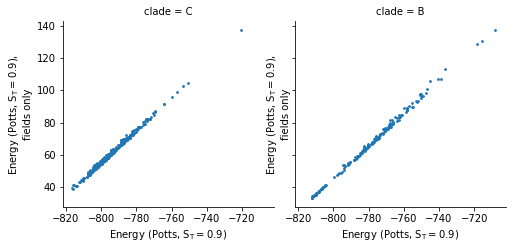

In [16]:
import seaborn as sns

w     = single_column
goldh = w
fig   = plot.figure(figsize=(w, goldh))

g  = sns.FacetGrid(exp_df, col='clade', margin_titles=True, height=w, aspect=1)
ax = g.map(plot.scatter, 'E90', 'h90', s=3)
ax.set(xlabel='Energy (Potts, '+r'$S_T=0.9)$', ylabel='Energy (Potts, '+r'$S_T=0.9)$'+',\nfields only')
plot.savefig('figures/figs5-E-vs-h.pdf', bbox_inches='tight', **figprops)
plot.close(fig)

### Figure S6. Comparison plots for functional measurements, clade B.

In [17]:
expVars = ['CD4','CXCR4','CCR5','HLA','CD74','infectivity','RC','d']
x, y    = [], []
xlim    = [[0., 100.] for i in range(len(expVars))]

for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        df = exp_df[[expVars[i],expVars[j],'clade']].dropna()
        df = df[df.clade=='B']
        x.append(np.array(df[expVars[j]],float))
        y.append(np.array(df[expVars[i]],float))
        
        xlim[j] = [np.min(x[-1]), np.max(x[-1])]
        xlim[i] = [np.min(y[-1]), np.max(y[-1])]
        
        if expVars[i]=='CD4' and expVars[j]=='RC':
            r_value, p_value = st.pearsonr(x[-1], y[-1])
            print('CD4-RC correlation (Pearson): r = %.2f, p = %.2e, n = %d' % (r_value, p_value, len(x[-1])))
            
        elif expVars[i]=='HLA' and expVars[j]=='RC':
            r_value, p_value = st.pearsonr(x[-1], y[-1])
            print('HLA-RC correlation (Pearson): r = %.2f, p = %.2e, n = %d' % (r_value, p_value, len(x[-1])))

labels = ['CD4\ndown-modulation', 'CXCR4\ndown-modulation', 'CCR5\ndown-modulation', 'HLA\ndown-modulation',
             'CD74 upregulation', 'Infectivity', 'Replication capacity', 'Distance\nfrom consensus']

labels = [k for k in expVars]

# Define plot

w     = one_five_column
goldh = w

fig  = plot.figure(figsize=(w, goldh))
gs   = gridspec.GridSpec(len(expVars)-1,len(expVars)-1)
ax   = [[0 for j in range(len(expVars)-1)] for i in range(len(expVars)-1)]
ax_b = []
    
for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        ax[i][j-1] = plot.subplot(gs[i, j-1])

# MAKE SUBPLOTS

print('\nPlotting matrix...')

xlabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
ylabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
scatterprops = { 'lw' : 0., 's' : 6., 'marker' : 'o', 'alpha' : 0.5 }
sigColor     = ['#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']

pprops = {  'colors'    : [bkcolor],
            'xticks'    : [],
            'yticks'    : [],
            'plotprops' : scatterprops,
            'theme'     : 'boxed' }

k = 0
for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        tempprops = deepcopy(pprops)
        tempprops['xlim'] = xlim[j]
        tempprops['ylim'] = xlim[i]
        if i==0:
            ax[i][j-1].set_xlabel(labels[j], **xlabelprops)
            ax[i][j-1].xaxis.set_label_position('top')
        if j==len(expVars)-1:
            ax[i][j-1].set_ylabel(labels[i], **ylabelprops)
            ax[i][j-1].yaxis.set_label_position('right')
        
        r_value, p_value = st.spearmanr(x[k], y[k])
        pexp             = np.floor(np.log10(p_value))
        pcoeff           = np.round(p_value * (10. ** (-pexp)))
        if   p_value<1e-4: tempprops['colors'] = [sigColor[3]]
        elif p_value<1e-3: tempprops['colors'] = [sigColor[2]]
        elif p_value<1e-2: tempprops['colors'] = [sigColor[1]]
        elif p_value<5e-2: tempprops['colors'] = [sigColor[0]]

        mp.plot(type='scatter', ax=ax[i][j-1], x=[x[k]], y=[y[k]], **tempprops)
        k += 1

axLG = plot.subplot(gs[4, 1])

legendprops  = { 'loc' : 1, 'frameon' : False, 'scatterpoints' : 1, 'handletextpad' : -0.25, 
                'prop' : {'size' : sizelabel-1}, 'bbox_to_anchor' : (0.45, 1.12), 'ncol' : 1 }

pprops = { 'xlim'   : [0, 1],
           'ylim'   : [0, 1],
           'xticks' : [],
           'yticks' : [],
           'hide'   : ['top', 'bottom', 'left', 'right']}

scatterprops = { 'lw' : 0., 's' : 6., 'marker' : 'o', 'alpha' : 0.5, 'label' : r'$p\geq 0.05$' }
mp.scatter(ax=axLG, x=[[-1]], y=[[-1]], colors=[bkcolor], plotprops=scatterprops, **pprops)
scatterprops['label'] = r'$p<0.05$'
mp.scatter(ax=axLG, x=[[-1]], y=[[-1]], colors=[sigColor[0]], plotprops=scatterprops, **pprops)
scatterprops['label'] = r'$p<0.01$'
mp.scatter(ax=axLG, x=[[-1]], y=[[-1]], colors=[sigColor[1]], plotprops=scatterprops, **pprops)
scatterprops['label'] = r'$p<0.001$'
mp.scatter(ax=axLG, x=[[-1]], y=[[-1]], colors=[sigColor[2]], plotprops=scatterprops, **pprops)
#scatterprops['label'] = r'$p<0.0001$'
#mp.scatter(ax=axLG, x=[[-1]], y=[[-1]], colors=[sigColor[3]], plotprops=scatterprops, **pprops)
del scatterprops['label']
pprops['legendprops'] = legendprops
mp.plot(type='scatter', ax=axLG, x=[[-1]], y=[[-1]], colors=[sigColor[3]], 
        legend=[r'$p<0.0001$'], plotprops=scatterprops, **pprops)

# Save data

#plot.tight_layout(h_pad=-3.3, w_pad=-3.7)
plot.savefig('figures/figs6-functional-matrix-B.pdf', **figprops)
plot.close(fig)

print('Done.')

CD4-RC correlation (Pearson): r = 0.49, p = 1.65e-08, n = 121
HLA-RC correlation (Pearson): r = 0.27, p = 2.46e-03, n = 121

Plotting matrix...
Done.


### Figure X1. Comparison plots for functional measurements, clade C.

In [18]:
expVars = ['CD4','HLA','d']
x, y    = [], []
xlim    = [[0., 100.] for i in range(len(expVars))]
xlim[-1] = [0., 0.3]

for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        df = exp_df[[expVars[i],expVars[j],'clade']].dropna()
        df = df[df.clade=='C']
        x.append(np.array(df[expVars[j]],float))
        y.append(np.array(df[expVars[i]],float))
        
        xlim[j] = [np.min(x[-1]), np.max(x[-1])]
        xlim[i] = [np.min(y[-1]), np.max(y[-1])]
        
        if expVars[i]=='CD4' and expVars[j]=='RC':
            r_value, p_value = st.pearsonr(x[-1], y[-1])
            print('CD4-RC correlation (Pearson): r = %.2f, p = %.2e, n = %d' % (r_value, p_value, len(x[-1])))
            
        elif expVars[i]=='HLA' and expVars[j]=='RC':
            r_value, p_value = st.pearsonr(x[-1], y[-1])
            print('HLA-RC correlation (Pearson): r = %.2f, p = %.2e, n = %d' % (r_value, p_value, len(x[-1])))
        
labels = ['CD4\ndown-modulation', 'CXCR4\ndown-modulation', 'CCR5\ndown-modulation', 'HLA\ndown-modulation',
             'CD74 upregulation', 'Infectivity', 'Replication capacity', 'Distance\nfrom consensus']

labels = [k for k in expVars]

# Define plot

w     = one_five_column * (3. / 8.)
goldh = w

fig  = plot.figure(figsize=(w, goldh))
gs   = gridspec.GridSpec(len(expVars),len(expVars))
ax   = [[0 for j in range(len(expVars))] for i in range(len(expVars))]
ax_b = []
    
for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        ax[i][j] = plot.subplot(gs[i, j])

# MAKE SUBPLOTS

print('Plotting matrix...')

xlabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
ylabelprops  = { 'family' : fontfamily, 'size' : sizelabel, 'color' : bkcolor, 'labelpad' : 2 }
scatterprops = { 'lw' : 0., 's' : 6., 'marker' : 'o', 'alpha' : 0.5 }

pprops = {  'colors'    : [bkcolor],
            'xticks'    : [],
            'yticks'    : [],
            'plotprops' : scatterprops,
            'theme'     : 'boxed' }

k = 0
for i in range(len(expVars)):
    for j in range(i+1,len(expVars)):
        tempprops = deepcopy(pprops)
        tempprops['xlim'] = xlim[j]
        tempprops['ylim'] = xlim[i]
        if i==0:
            ax[i][j].set_xlabel(labels[j], **xlabelprops)
            ax[i][j].xaxis.set_label_position('top')
        if j==len(expVars)-1:
            ax[i][j].set_ylabel(labels[i], **ylabelprops)
            ax[i][j].yaxis.set_label_position('right')

        mp.plot(type='scatter', ax=ax[i][j], x=[x[k]], y=[y[k]], **tempprops)
        k += 1
        
# Save data

#plot.tight_layout(pad=0.1)
plot.savefig('figures/figx1-functional-matrix-C.pdf', **figprops)
plot.close(fig)

print('Done.')

Plotting matrix...
Done.


### Figures X2 and X3. CD4 and HLA down-modulation replicates for synthetic sequences.

In [19]:
import seaborn as sns

df = pd.read_csv('input/CD4-replicates.csv')

w     = single_column
goldh = w
fig   = plot.figure(figsize=(w, goldh))

ax = sns.scatterplot(x='r1', y='r2', data=df)
ax.set(xlabel='CD4 down-modulation,\nreplicate 1', ylabel='CD4 down-modulation,\nreplicate 2')
plot.savefig('figures/figx2-CD4-replicates.pdf', bbox_inches='tight', **figprops)
plot.close(fig)

In [20]:
import seaborn as sns

df = pd.read_csv('input/HLA-replicates.csv')

w     = single_column
goldh = w
fig   = plot.figure(figsize=(w, goldh))

ax = sns.scatterplot(x='r1', y='r2', data=df)
ax.set(xlabel='HLA down-modulation,\nreplicate 1', ylabel='HLA down-modulation,\nreplicate 2')
plot.savefig('figures/figx3-HLA-replicates.pdf', bbox_inches='tight', **figprops)
plot.close(fig)